In [135]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Inter-SM sharing pairs

In [296]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
inter_pkl = os.path.join(PKL_PATH, 'inter.pkl')
csv = os.path.join(HOME, 'data/csv/pair_inter.csv')
output = os.path.join(PKL_PATH, 'pair_inter.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --how inter --isolated_pkl $inter_pkl

In [297]:
df_inter = pd.read_pickle(output)
print(df_inter.shape)
df_inter.sort_values(['1_bench', '2_bench'], inplace=True)
df_inter.reset_index(inplace=True, drop=True)

# FIXME: drop any rows with zero fairness
df_inter = df_inter[df_inter['fairness'] > 0]


(405, 231)


In [298]:
# Only show best performance for each benchmark pair
df_inter_show = df_inter.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_inter_show.reset_index(inplace=True, drop=True)
# df_inter_show = df_inter_show[(df_inter_show['1_bench']=='parb_lbm-0')|(df_inter_show['2_bench']=='parb_lbm-0')]

# df_inter_show['delta'] = df_inter_show['norm_ipc_sum'] - df_inter_show['ws']

col_inter_show = ['1_bench', '1_inter', '1_sld', 
                    '2_bench', '2_inter', '2_sld', 'ws', 'fairness', 'norm_ipc_sum']
draw_table(df_inter_show, col_inter_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                         'avg_dram_bw_y':'{:.4f}',
                                                        })

,1_bench,1_inter,1_sld,2_bench,2_inter,2_sld,ws,fairness,norm_ipc_sum
0,parb_cutcp-0,52,1.00309,rod_heartwall-0,28,1.05283,2.05591,0.952756,nan
1,nvd_blackscholes-0,40,0.996233,parb_cutcp-0,40,0.971767,1.968,0.975442,nan
2,nvd_interval-0,60,0.980353,parb_cutcp-0,20,0.985887,1.96624,0.994386,nan
3,nvd_interval-0,52,0.955376,rod_heartwall-0,28,1.00699,1.96237,0.948743,nan
4,parb_cutcp-0,20,0.971141,parb_spmv-0,60,0.983206,1.95435,0.987729,nan
5,parb_cutcp-0,36,0.981885,parb_stencil-0,44,0.971572,1.95346,0.989497,nan
6,nvd_blackscholes-0,44,1.01996,rod_heartwall-0,36,0.921436,1.9414,0.903405,nan
7,parb_cutcp-0,16,0.959332,rod_streamcluster-0,64,0.974202,1.93353,0.984736,nan
8,parb_cutcp-0,40,0.947682,parb_lbm-0,40,0.981951,1.92963,0.965101,nan
9,cut_wmma-0,48,0.927393,parb_cutcp-0,32,0.992023,1.91942,0.93485,nan


=== inter-SM stats ===
** Total **
Pairs:  135
WS geomean: 1.3156
------------------------------
** Greater than 1.0 WS **
Proportion: 0.87
WS geomean: 1.3768
------------------------------
** Greater than 1.5 WS **
Proportion: 0.30
WS geomean:  1.7544


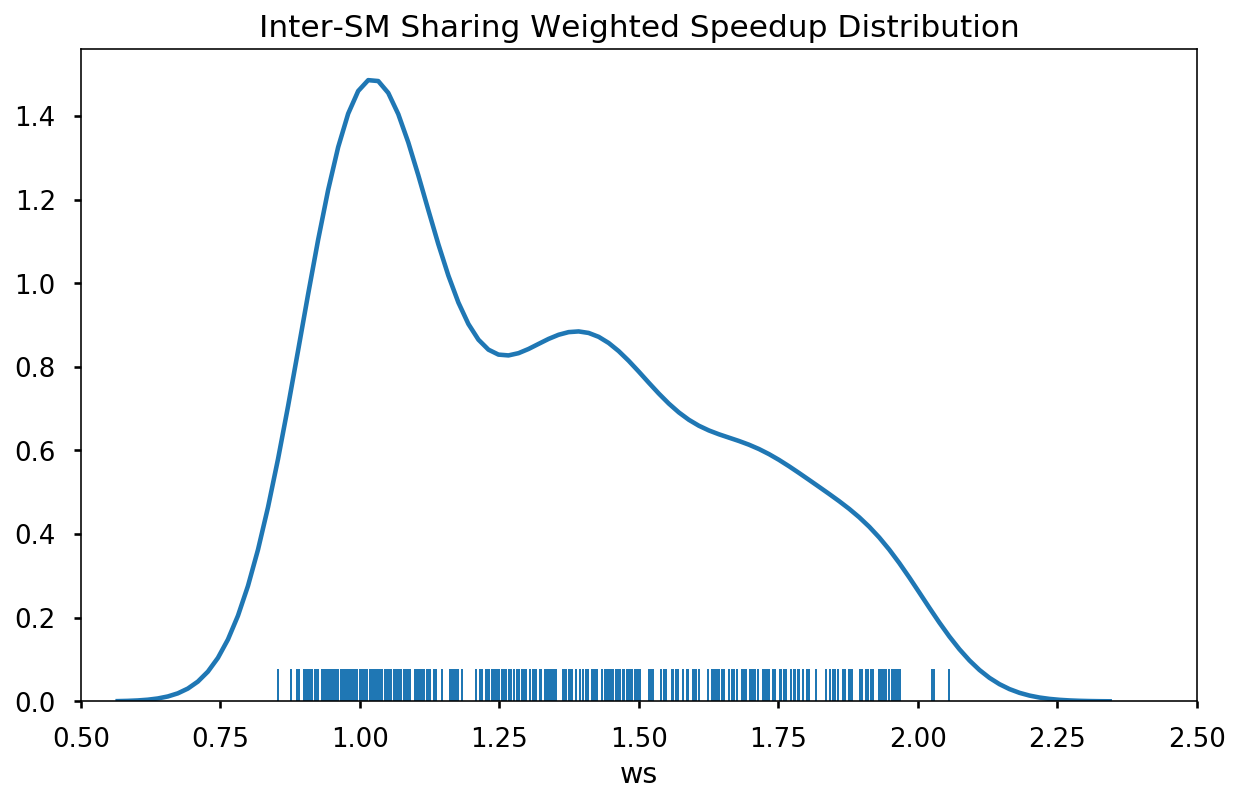

In [299]:
print('=== inter-SM stats ===')
print('** Total **')
print('Pairs: ', len(df_inter_show))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_show['ws']))
# print('Naive prediction average delta: %.2f'% np.average(df_inter_show['delta']))

print('-'*30)

df_gt_1_inter = df_inter_show[df_inter_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_show.index)))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['ws']))
# print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

print('-'*30)

df_gt_15_inter = df_inter_show[df_inter_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_show.index)))
print('WS geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['ws']))
# print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_inter['ws'], hist=False, rug=True);
plt.xlim([0.5, 2.5])
plt.title('Inter-SM Sharing Weighted Speedup Distribution')
plt.show()

In [265]:
# print('=== Ideal inter-SM stats ===')
# # predicted norm_ipc_sum of inter-SM
# df_inter_max = df_inter.dropna()
# print('** Total **')
# print('norm_ipc_sum geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_max['norm_ipc_sum']))

# print('-'*30)

# df_gt_1_inter = df_inter_max[df_inter_max['norm_ipc_sum'] > 1.0]
# print('** Greater than 1.0 norm_ipc_sum **')
# print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_max.index)))
# print('norm_ipc_sum geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['norm_ipc_sum']))
# # print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

# print('-'*30)

# df_gt_15_inter = df_inter_max[df_inter_max['norm_ipc_sum'] > 1.5]
# print('** Greater than 1.5 norm_ipc_sum **')
# print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_max.index)))
# print('norm_ipc_sum geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['norm_ipc_sum']))
# # print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

# plt.figure(figsize=(10, 6))
# sns.distplot(df_inter_max['norm_ipc_sum'], hist=False, rug=True);
# plt.title('(Ideal) Inter-SM Sharing Weighted Speedup Distribution')
# plt.show()

# Intra-SM sharing pairs

In [283]:
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
print(df_dynamic.shape)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)


(1436, 257)


In [284]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

df_dynamic_show['delta'] = df_dynamic_show['sum_ipc'] - df_dynamic_show['ws']

col_dynamic_show = ['1_bench', 'intra_x', '1_sld', 
                    '2_bench', 'intra_y', '2_sld', 'ws', 'fairness', 'delta']
draw_table(df_dynamic_show, col_dynamic_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                             'avg_dram_bw_y':'{:.4f}',
                                                             'sum_bw_x':'{:.4f}',
                                                             'delta': '{:.2f}'
                                                            })

,1_bench,intra_x,1_sld,2_bench,intra_y,2_sld,ws,fairness,delta
0,nvd_binomial-0,8,0.977654,parb_spmv-0,8,1.06215,2.0398,0.920447,0.04
1,parb_cutcp-0,2,0.993212,rod_heartwall-0,1,1.02495,2.01817,0.96903,-0.02
2,parb_cutcp-0,2,0.967691,parb_spmv-0,6,1.03856,2.00625,0.931764,0.07
3,parb_cutcp-0,2,0.969548,parb_stencil-0,4,1.03095,2.0005,0.940442,0.05
4,nvd_interval-0,6,1.05843,parb_cutcp-0,2,0.940004,1.99844,0.88811,0.06
5,nvd_blackscholes-0,4,1.01356,parb_cutcp-0,2,0.968685,1.98224,0.955728,0.05
6,nvd_blackscholes-0,6,0.927284,rod_lavamd-0,6,1.04725,1.97453,0.885449,0.18
7,nvd_interval-0,6,1.04826,rod_heartwall-0,1,0.92388,1.97214,0.881344,0.09
8,parb_spmv-0,8,1.00107,rod_lavamd-0,4,0.957624,1.9587,0.956596,0.16
9,nvd_binomial-0,13,1.04584,rod_heartwall-0,1,0.909719,1.95556,0.869846,0.04


=== intra-SM stats ===
** Total **
Pairs:  135
WS geomean: 1.4454
Naive prediction average delta: 0.42
------------------------------
** Greater than 1.0 WS **
Proportion: 0.93
WS geomean: 1.4886
Greater than 1.0 naive delta: 0.40
------------------------------
** Greater than 1.5 WS **
Proportion: 0.52
WS geomean: 1.7503
Greater than 1.5 naive delta: 0.21


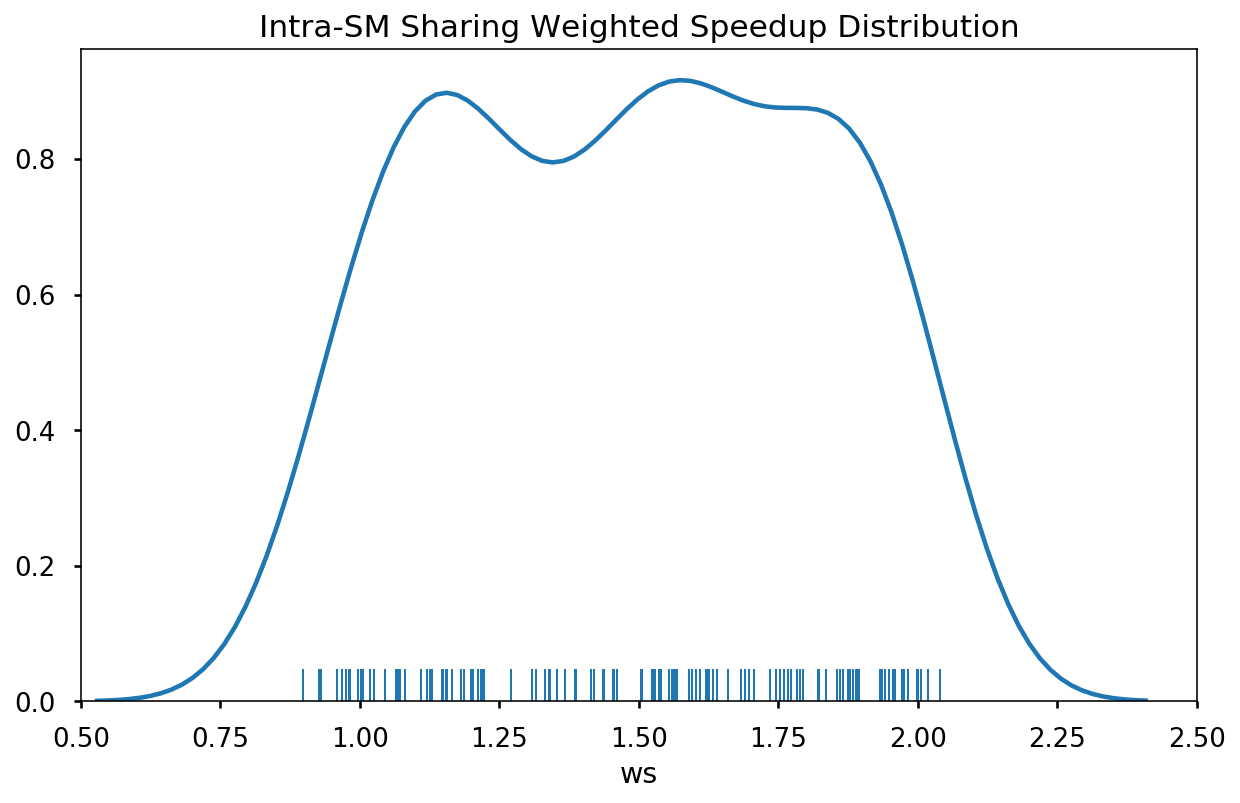

In [285]:
print('=== intra-SM stats ===')
print('** Total **')
print('Pairs: ', len(df_dynamic_show.index))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['ws']))
print('Naive prediction average delta: %.2f' % np.average(df_dynamic_show['delta']))

print('-'*30)

df_gt_1_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['ws']))
print('Greater than 1.0 naive delta: %.2f' % np.average(df_gt_1_intra['delta']))

print('-'*30)

df_gt_15_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['ws']))
print('Greater than 1.5 naive delta: %.2f' % np.average(df_gt_15_intra['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_dynamic_show['ws'], hist=False, rug=True);
plt.xlim([0.5, 2.5])
plt.title('Intra-SM Sharing Weighted Speedup Distribution')
plt.show()

In [266]:
# print('=== Ideal intra-SM stats ===')
# print('** Total **')
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['sum_ipc']))

# print('-'*30)

# df_gt_1_intra = df_dynamic_show[df_dynamic_show['sum_ipc'] > 1.0]
# print('** Greater than 1.0 WS **')
# print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['sum_ipc']))

# print('-'*30)

# df_gt_15_intra = df_dynamic_show[df_dynamic_show['sum_ipc'] > 1.5]
# print('** Greater than 1.5 WS **')
# print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['sum_ipc']))

# plt.figure(figsize=(10, 6))
# sns.distplot(df_dynamic_show['sum_ipc'], hist=False, rug=True);
# plt.title('(Ideal) Intra-SM Sharing Weighted Speedup Distribution')
# plt.show()

# Compare Inter-SM and Intra-SM

In [288]:
df_both = pd.merge(df_inter_show, df_dynamic_show, on=['1_bench', '2_bench'], suffixes=('_inter', '_intra'))
df_both['intra-inter'] = df_both['ws_intra'] - df_both['ws_inter']
df_both['diff_mf_lat'] = np.absolute(df_both['1_avg_mem_lat_intra'] - df_both['2_avg_mem_lat_intra'])

# for c in df_both.columns:
#     print(c)
    

col_both = ['1_bench', '2_bench', #'ws_inter', 'ws_intra', 
            'intra-inter', 
            '1_sld_inter', '2_sld_inter', '1_sld_intra', '2_sld_intra',
#             'avg_dram_bw_x_intra', 'avg_dram_bw_y_intra',
            'scoreboard_cycles_x_intra', 'scoreboard_cycles_y_intra',
#             'l2_BW_x_intra', 'l2_BW_y_intra',
            '1_conc_cta_delta', '2_conc_cta_delta',
            '1_intra', '2_intra', '1_inter', '2_inter',
           ]

df_both['1_conc_cta_delta'] = df_both['1_conc_cta_intra'] - df_both['1_conc_cta_inter']
df_both['2_conc_cta_delta'] = df_both['2_conc_cta_intra'] - df_both['2_conc_cta_inter']

def highlight_error(s):
    is_neg = s < 0
    return ['background-color: yellow' if v else '' for v in is_neg]


df_both_display = df_both#[df_both['intra-inter']<0]

# pattern: small grids favor inter-SM sharing
# small_grid = ['parb_cutcp-0', 'rod_heartwall-0', 'rod_streamcluster-0']
# df_both_display = df_both_display[(~df_both_display['1_bench'].isin(small_grid))&(~df_both_display['2_bench'].isin(small_grid))]

target = 'parb_lbm-0'
df_both_display = df_both_display[(df_both_display['1_bench']==target)|(df_both_display['2_bench']==target)]

df_both_display = df_both_display.sort_values('intra-inter')

print('Num of rows: ', df_both_display.shape[0])
draw_table(df_both_display, col_both, True).apply(highlight_error, subset=['intra-inter'])

Num of rows:  16


1_bench,2_bench,intra-inter,1_sld_inter,2_sld_inter,1_sld_intra,2_sld_intra,scoreboard_cycles_x_intra,scoreboard_cycles_y_intra,1_conc_cta_delta,2_conc_cta_delta,1_intra,2_intra,1_inter,2_inter
parb_lbm-0,rod_heartwall-0,-0.190125,0.982441,0.595677,0.94976,0.438233,21.91,15.56,-464,0,2,1,52,28
parb_lbm-0,rod_hotspot-0,-0.165614,0.832185,0.515055,0.738321,0.443306,21.91,8.91,-272,128,2,6,36,44
parb_cutcp-0,parb_lbm-0,-0.0464156,0.947682,0.981951,0.925621,0.957595,9.23,21.91,0,-320,2,2,40,40
parb_lbm-0,rod_streamcluster-0,-0.0224988,0.811254,0.142196,0.785633,0.145319,76.51,44.75,160,-40,8,1,40,40
nvd_blackscholes-0,parb_lbm-0,0.010465,0.495088,0.491279,0.174669,0.822164,16.65,97.41,-544,368,2,10,44,36
parb_lbm-0,rod_pathfinder-0,0.0144325,0.80643,0.244076,0.613283,0.451656,21.91,11.98,-416,207,2,6,48,32
nvd_interval-0,parb_lbm-0,0.0210969,0.77385,0.894898,0.831606,0.858239,9.78,21.91,-48,-272,6,2,44,36
nvd_fdtd3d-0,parb_lbm-0,0.0304542,0.161837,0.825342,0.223041,0.794592,15.61,38.89,36,-112,1,4,44,36
parb_lbm-0,parb_stencil-0,0.0330224,0.553763,0.414556,0.669687,0.331655,56.56,11.01,-96,-192,6,4,48,32
nvd_sobol-0,parb_lbm-0,0.0333989,0.376827,0.659741,0.4538,0.616167,7.21,56.56,128,-48,16,6,36,44


In [289]:
pref = []
for kernel in list(const.app_dict.keys()):
    df_kernel = df_both[(df_both['1_bench']==kernel)|(df_both['2_bench']==kernel)]
    prefer_inter = len(df_kernel[df_kernel['intra-inter']<-0.001].index) / len(df_kernel.index)
    pref.append((kernel, prefer_inter, const.app_dict[kernel][1], const.app_dict[kernel][0]))
    
    
df_pref = pd.DataFrame(pref, columns=['kernel', 'prefer inter', 'grid size', 'max cta/SM'])
df_pref['grid/max'] = df_pref['grid size'] / df_pref['max cta/SM']
df_pref.sort_values('prefer inter', inplace=True)

draw_table(df_pref, df_pref.columns).format({'grid/max': '{:.0f}'})

kernel,prefer inter,grid size,max cta/SM,grid/max
rod_lavamd-0,0,1000,9,111
rod_hotspot3d-0,0.0625,1024,8,128
nvd_blackscholes-0,0.0625,15625,16,977
nvd_binomial-0,0.0625,1024,16,64
nvd_interval-0,0.0625,1024,12,85
nvd_sobol-0,0.0666667,51200,32,1600
rod_pathfinder-0,0.125,463,8,58
parb_stencil-0,0.125,1024,16,64
parb_spmv-0,0.125,1147,16,72
nvd_fdtd3d-0,0.142857,288,1,288


# Compare C+C pairs

In [290]:
def highlight_usage(s):
    colors = []
    for v in s:
        if v < 0.1:
            colors.append('background-color: green')
        elif v < 0.2:
            colors.append('background-color: yellow')
        else:
            colors.append('background-color: red')
    return colors

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_comp = df_seq[df_seq.apply(lambda x: (const.app_dict[x['pair_str']][2] == 1),axis=1)]
df_comp.set_index('pair_str', inplace=True)

col_seq = ['sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy']
draw_table(df_comp, col_seq, False).apply(highlight_usage, 
                                         subset=['sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy'])


,sp_busy,dp_busy,int_busy,tensor_busy,sfu_busy
pair_str,,,,,
cut_sgemm-1,0.351627,0,0.147064,0,0
cut_wmma-0,0.000967,0,0.051946,0.240054,0
nvd_binomial-0,0.378521,0,0.039163,0,0.001047
nvd_sobol-0,0.017147,0,0.48315,0,0
parb_cutcp-0,0.045542,0,0.013996,0,0.022947
rod_heartwall-0,0,0,0.027635,0,0.016938
rod_hotspot-0,0.022402,0.184569,0.32232,0,0.062064
rod_lavamd-0,0.012069,0.597422,0.117729,0,0
rod_pathfinder-0,0,0,0.359393,0,0


In [295]:
def comp_comp(row):
    return row['1_bench'] in df_comp.index and row['2_bench'] in df_comp.index

df_cc = df_both[df_both.apply(comp_comp, axis=1)].copy()
df_cc.reset_index(inplace=True, drop=True)

def sum_usage(row, metric):
    return (df_comp.loc[row['1_bench'], metric] > 0.1) and (df_comp.loc[row['2_bench'], metric] > 0.1)

df_cc['sp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sp_busy'), axis=1)
df_cc['dp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'dp_busy'), axis=1)
df_cc['int_sum'] = df_cc.apply(lambda row: sum_usage(row, 'int_busy'), axis=1)
df_cc['tensor_sum'] = df_cc.apply(lambda row: sum_usage(row, 'tensor_busy'), axis=1)
df_cc['sfu_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sfu_busy'), axis=1)

df_cc['1_conc_cta_delta'] = df_cc['1_conc_cta_intra'] - df_cc['1_conc_cta_inter']
df_cc['2_conc_cta_delta'] = df_cc['2_conc_cta_intra'] - df_cc['2_conc_cta_inter']

col_cc = col_both + ['1_conc_cta_delta', '2_conc_cta_delta', 
                     'sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum']

def highlight_conflict(s):
    is_conflict = (s == True)
    return ['background-color: yellow' if v else '' for v in is_conflict]

df_cc[col_cc]
# draw_table(df_cc, col_cc, False).apply(highlight_conflict, 
#                                        subset=['sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum'])

,1_bench,2_bench,intra-inter,1_sld_inter,2_sld_inter,1_sld_intra,2_sld_intra,scoreboard_cycles_x_intra,scoreboard_cycles_y_intra,1_conc_cta_delta,...,2_intra,1_inter,2_inter,1_conc_cta_delta,2_conc_cta_delta,sp_sum,dp_sum,int_sum,tensor_sum,sfu_sum
0,parb_cutcp-0,rod_heartwall-0,-0.037747,1.003087,1.052826,0.993212,1.024955,9.23,15.56,0.0,...,1.0,52.0,28.0,0.0,0.0,False,False,False,False,False
1,cut_wmma-0,parb_cutcp-0,0.013496,0.927393,0.992023,0.972867,0.960046,4.67,9.23,0.0,...,2.0,48.0,32.0,0.0,0.0,False,False,False,False,False
2,parb_cutcp-0,rod_pathfinder-0,-0.060075,0.921274,0.960750,0.861231,0.960717,9.23,11.98,0.0,...,6.0,12.0,68.0,0.0,0.0,False,False,False,False,False
3,cut_wmma-0,rod_heartwall-0,-0.042344,0.916904,0.960348,0.940999,0.893909,4.67,15.56,0.0,...,1.0,48.0,32.0,0.0,0.0,False,False,False,False,False
4,cut_sgemm-1,parb_cutcp-0,-0.232879,0.821417,0.971965,0.678892,0.881611,1.96,9.23,-48.0,...,2.0,64.0,16.0,-48.0,0.0,False,False,False,False,False
5,parb_cutcp-0,rod_lavamd-0,0.155322,0.922292,0.863939,0.851710,1.089843,9.23,9.60,0.0,...,6.0,12.0,68.0,0.0,-132.0,False,False,False,False,False
6,nvd_sobol-0,parb_cutcp-0,-0.025543,0.789843,0.970502,0.902284,0.832518,7.21,9.23,-768.0,...,2.0,64.0,16.0,-768.0,0.0,False,False,False,False,False
7,rod_heartwall-0,rod_pathfinder-0,-0.050844,0.880430,0.853284,0.704218,0.978653,15.56,11.98,0.0,...,6.0,20.0,60.0,0.0,0.0,False,False,False,False,False
8,nvd_binomial-0,parb_cutcp-0,-0.136508,0.939720,0.785982,0.683104,0.906091,3.87,9.23,-704.0,...,2.0,72.0,8.0,-704.0,0.0,False,False,False,False,False
9,parb_cutcp-0,rod_hotspot-0,-0.096200,0.969700,0.722281,0.854356,0.741424,9.23,7.58,0.0,...,4.0,16.0,64.0,0.0,-192.0,False,False,False,False,False


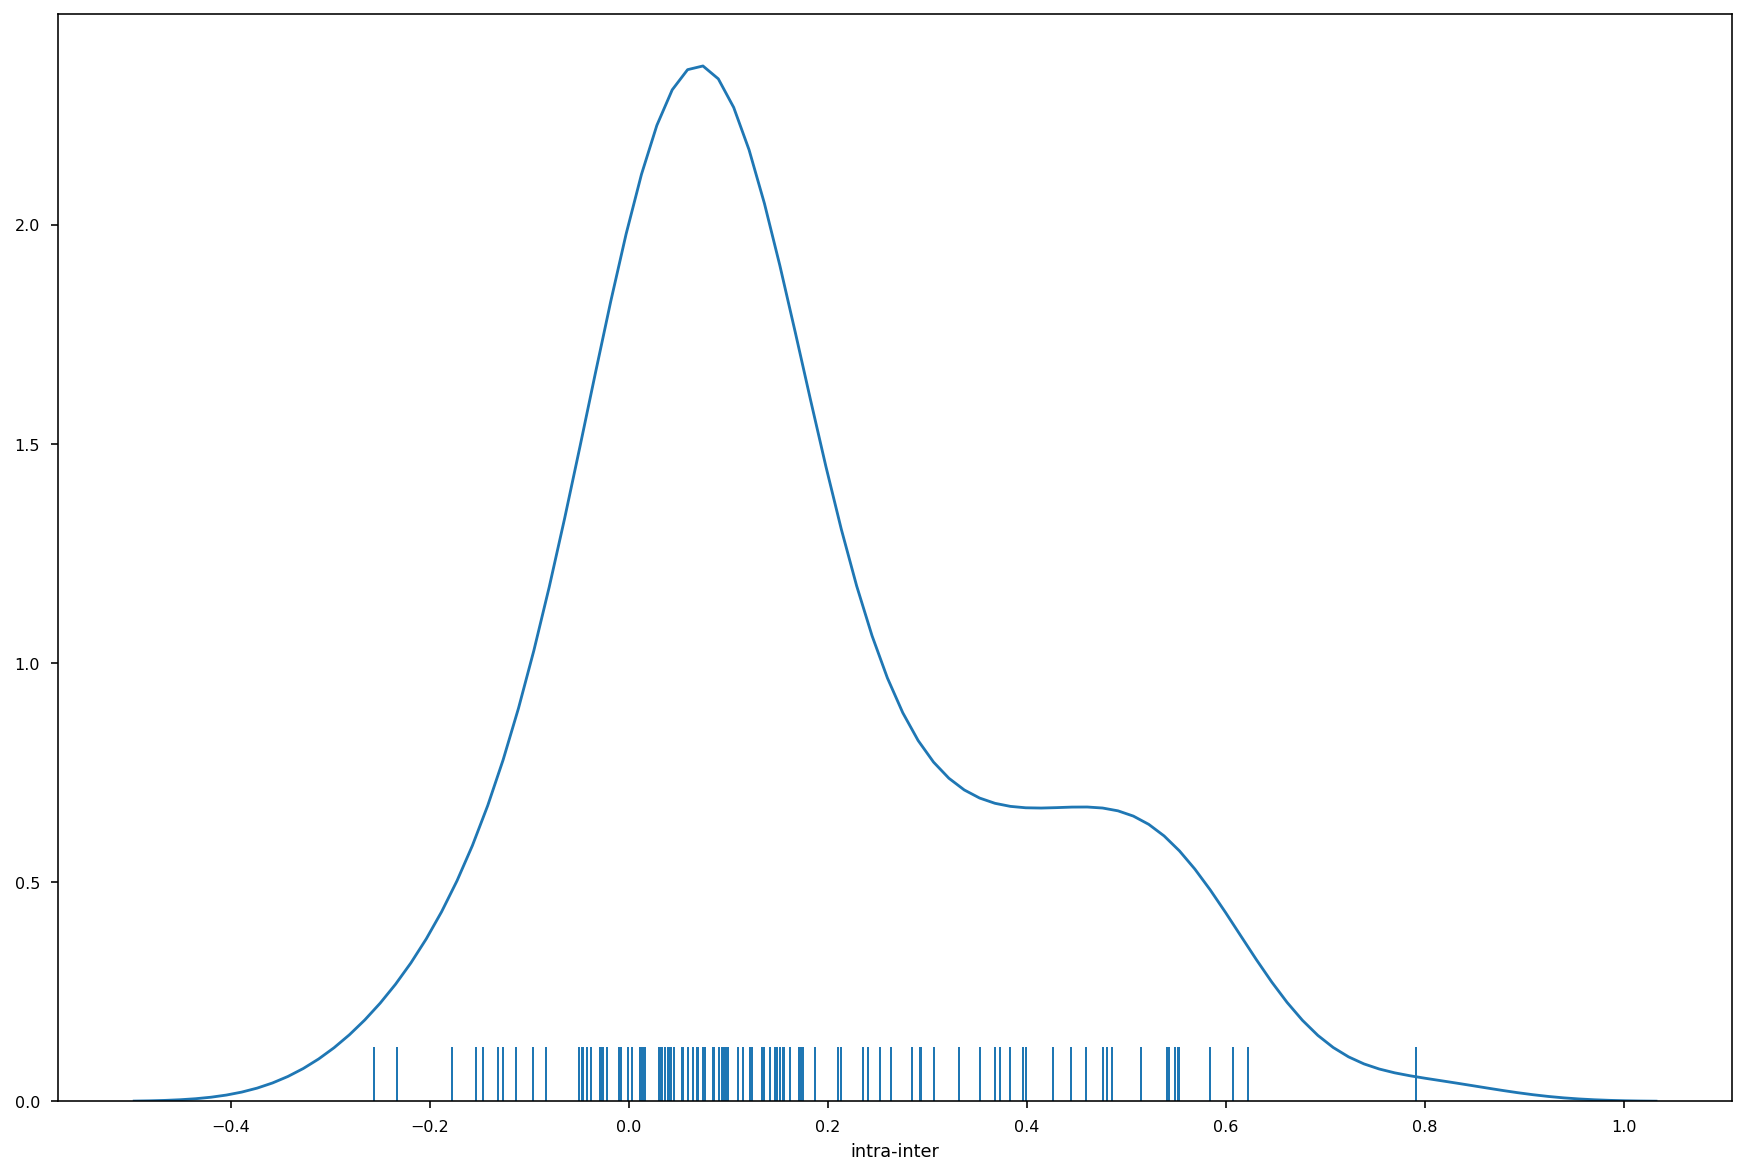

In [127]:
plt.figure(figsize=(15, 10))
sns.distplot(df_both['intra-inter'], hist=False, rug=True);
plt.show()